In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt


In [2]:
np.random.seed(1)

# Problem setup:

We're going to have a small number of (X, Y) data points.
We will see how the model misfit changes as we increase the number of parameters.
The type of model we'll use is a sum of sines and cosines of increasing frequency. The model parameters are the amplitudes of these sinusoids. 
That is, given the m data points $(x_1, y_1) ,\ldots, (x_m, y_m)$ , we'll fit

\begin{align}
y_i = a_0 + a_1 \cos(x_i) + a_2 \cos(2x_i) + \ldots a_n \cos(nx_i) + b_1 \sin(x_i) + \ldots + b_n \sin(nx_i)
\end{align}

But before we work with this, we'll first show what happens with Numpy's `Polynomial.fit` function, which is often used to show the danger of high complexity model fitting.

# Make the truth data: all zeros, but there's one noise point at 1

For illustration purposes, the data generation process will just be all zeros. But we'll add noise to one single point to move it from 0 to 1.


An omniscient model would ignore the noise point and predict all zeros... but it will try to fit through that noise point at y=1.


In [3]:
X_MAX = 2 * np.pi
def make_data(m):
    # Make Xs scattered on interval [0, 2pi]
    X = X_MAX * np.random.rand(m,)
    # Y's are all zero (1e-10 for plotting purposes)
    Y = 1e-9 + np.zeros((m,))
    # ...except for one noise point
    Y[m//2] = 1
    return X, Y


# Traditional model-fitting explanation: Use fewer parameters than data (n << m)


<IPython.core.display.Javascript object>


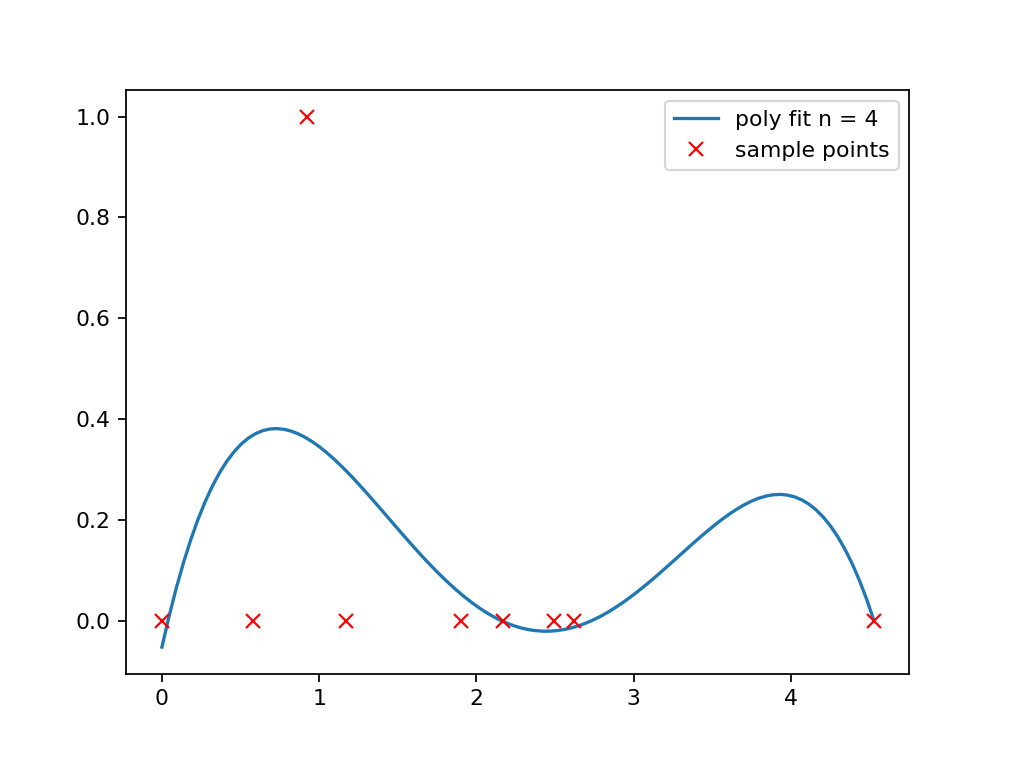

In [4]:
from numpy.polynomial import Polynomial
m = 9
X, Y = make_data(m)

n = 4

p = Polynomial.fit(X, Y, n)
xx, yy = p.linspace(domain=[np.min(X), np.max(X)])
plt.figure()
plt.plot(xx, yy, label=f"poly fit {n = }")
plt.plot(X, Y, 'rx', label='sample points')
plt.legend()

Here a polynomial won't be look great, but it's relatively stable in the region around the data.

However, the fit becomes unstable as the order increases up to the number of data points, and the errors go crazy goes crazy.

/Users/scott/opt/anaconda3/envs/mapping/lib/python3.8/site-packages/numpy/polynomial/polynomial.py:1350: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


<IPython.core.display.Javascript object>


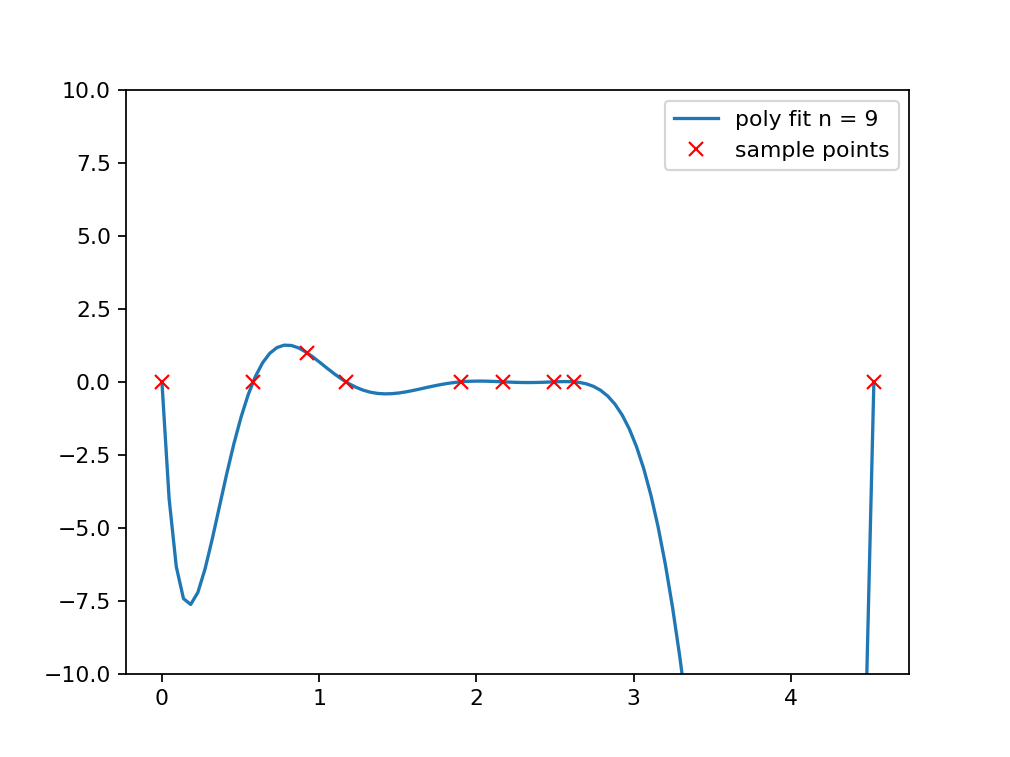

In [5]:
n = 9
p = Polynomial.fit(X, Y, n)
xx, yy = p.linspace(domain=[np.min(X), np.max(X)])
plt.figure()
plt.plot(xx, yy, label=f"poly fit {n = }")
plt.plot(X, Y, 'rx', label='sample points')
plt.ylim(-10, 10)
plt.legend()

The points are all interpolated here, but the fit inbetween is terrible. This is generally shown to be the reason for keeping model complexity low compared to the size of the data.

# Back to the sine/cosine model:

Now to show what happens as we increase the number of model parameters above and beyond the number of data points, we'll use the Fourier model:

\begin{align}
y_i = a_0 + a_1 \cos(x_i) + a_2 \cos(2x_i) + \ldots a_n \cos(nx_i) + b_1 \sin(x_i) + \ldots + b_n \sin(nx_i)
\end{align}

(Note that we're using this sine/cosine model to match [1], and because the `Polynomial.fit` fails for when the `deg`, polynomial order, exceeds `m`, the number of points).


Below are the functions for the making $\mathbf{A}$ matrix for fitting the system $\mathbf{y = Ax}$, along with `fit()` and `predict()` functions for the model:

In [6]:
def form_A(X, order):
    # N is the highest order sin/cos, so num terms is n = 2order + 1
    # X has m data points
    m = X.shape[0]
    A = np.zeros((m, 2*order + 1))
    A[:, 0] = 1
    for k in range(1, order + 1):
        A[:, k] = np.cos(X * k)
        A[:, k + order] = np.sin(X * k)
    return A

def predict(coeffs, xs):
    """Take in the coefficients of the sin/cosine terms from the fitting,
    along with the x locations, and output the model predicted ys
    
    The `coeffs` vector are the a_i and b_i cos/sin coefficients"""
    order = (len(coeffs) - 1) // 2
    m = len(xs)
    idxs = np.arange(1, order+1).reshape((1, order))
    a0 = coeffs[0]
    cos_terms = np.sum(coeffs[1:(order+1)] * np.cos(xs.reshape((-1, 1)) * idxs), axis=1)
    sin_terms = np.sum(coeffs[order+1:] * np.sin(xs.reshape((-1, 1)) * idxs), axis=1)
    ys = a0 + cos_terms + sin_terms
    return ys


def calculate_avg_misfit(y_hat, y_truth = 0):
    # The real data should be all 0s (except that one noisy point), so a 0 line would be perfect
    return np.sum(np.abs(y_hat - y_truth)) / len(y_hat)

def fit(X, Y, order, x_test=None, x_max=X_MAX, print_misfit=True):
    """Fit the sin/cos model, return the [a_i, b_i] coefficients"""
    A = form_A(X, order)
    
    m = len(X)
    n = 2*order + 1
    assert A.shape == (m, n)
    # If overdetermined system (m > n, more data points (rows) than features (columns)), 
    # this would be a least squares fitting of the model.
    # coeffs = np.linalg.lstsq(A, Y, rcond=None)[0]
    # For fat A (m < n), we'll use the pseudoinverse to fit
    coeffs = np.linalg.pinv(A) @ Y
    if x_test is None:
        x_test = np.linspace(0, X_MAX, 500)
    y_hat = predict(coeffs, x_test)
    
    misfit = calculate_avg_misfit(y_hat)
    if print_misfit:
        print(f"Average misfit: {misfit}")
    return x_test, y_hat, misfit


## Case: m > n, more data points than model parameters

The model does it's best to fit all points, but there are fewer parameters than data points, so we're doing a least-squares regression

Average misfit: 1.9714393403195682


<IPython.core.display.Javascript object>


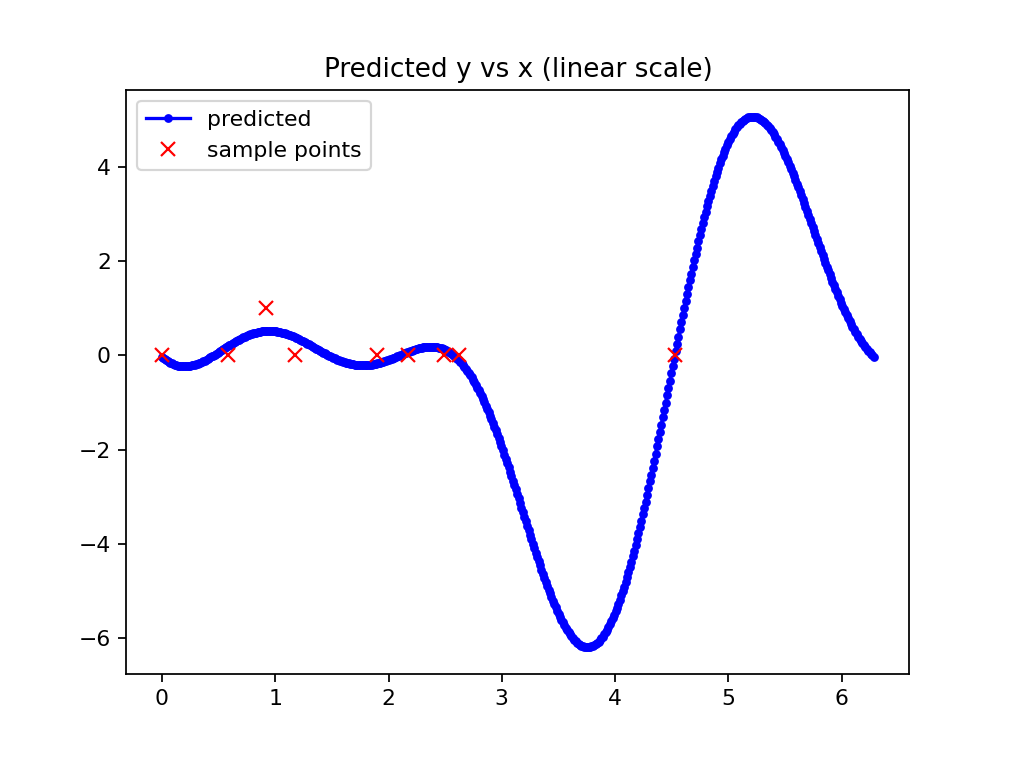

In [7]:
# m = Number of data points
# n = Number of parameters to fit
# m = 9
# X, Y = make_data(m)

order = 3
# n = 2*order + 1

x_test, y_hat, misfit = fit(X, Y, order)

plt.figure()
plt.plot(x_test, y_hat, 'b.-', label='predicted')
plt.plot(X, Y, 'rx', label='sample points')
plt.title("Predicted y vs x (linear scale)")
plt.legend()

For a more "energy-like" view, we'll plot in a log scale. Any peaks above 0 can be considered "noise energy", as the truth would be all 0s.

<IPython.core.display.Javascript object>


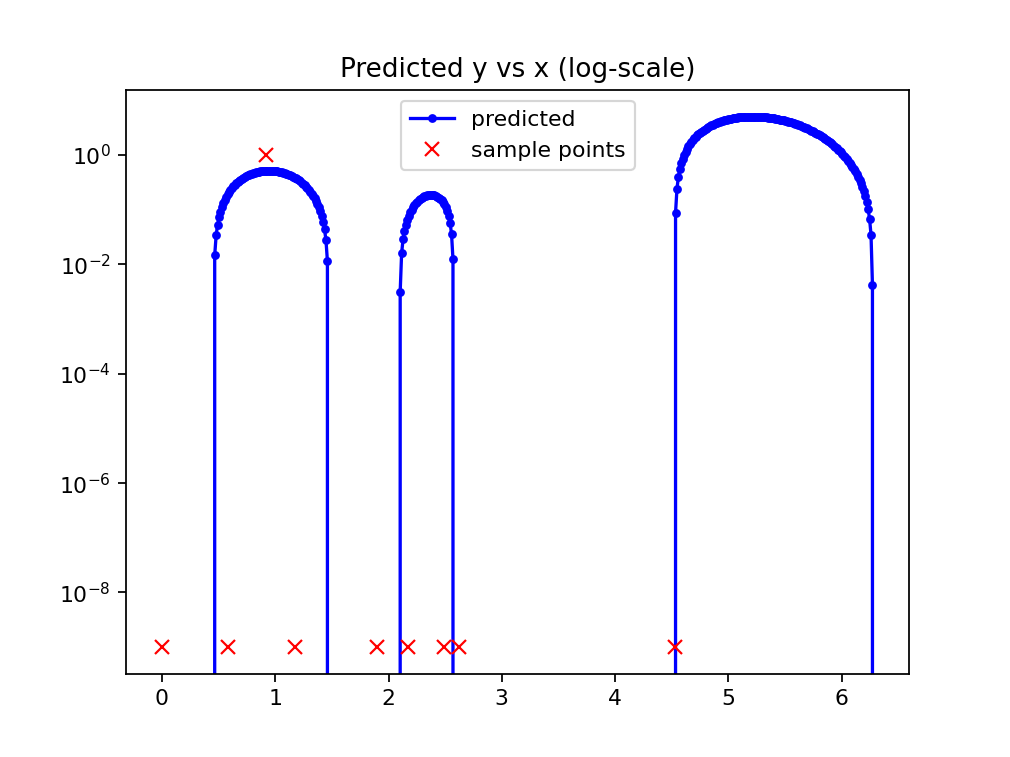

In [8]:
plt.figure()
plt.semilogy(x_test, y_hat, 'b.-', label='predicted')
plt.semilogy(X, Y, 'rx', label='sample points')
plt.title("Predicted y vs x (log-scale)")
plt.legend()

The model has `order` number of large humps, where large, badly-fitting spikes occur (where the humps might wrap around the `2 pi` point, since the sines/cosines are periodic there).

# Overfitting: m == n
The number of sin and cosine terms will now be equal to the number of data points to fit. 

This is the **worst-case scenario** here, where we can interpolate the data (match the training points exactly), but in between those, the model goes wildly off the rails (just like with the polynomail fit).

Average misfit: 20.355497441416627


<IPython.core.display.Javascript object>


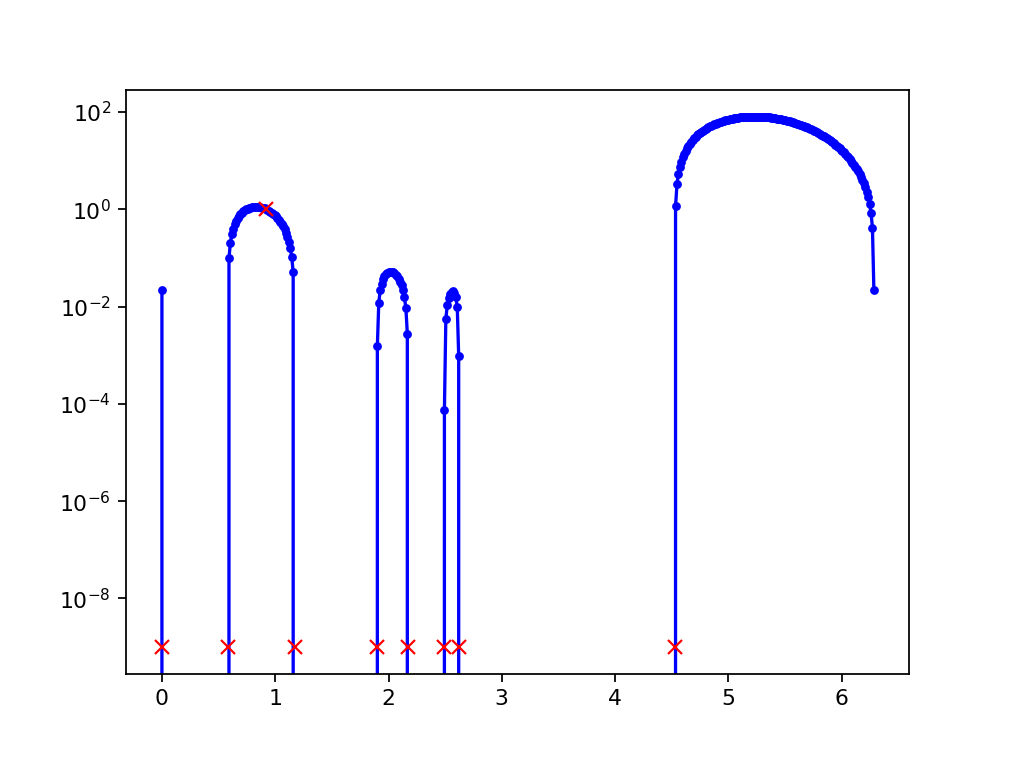

In [9]:
order = m // 2
n = 2*order + 1
assert n == m

x_test, y_hat, misfit = fit(X, Y, order)

plt.figure()
plt.semilogy(x_test, y_hat, 'b.-')
plt.semilogy(X, Y, 'rx')
plt.show()

# Overfitting? Try n > m
Let's use twice as many parameters as data points

Average misfit: 0.15200455330631488


<IPython.core.display.Javascript object>


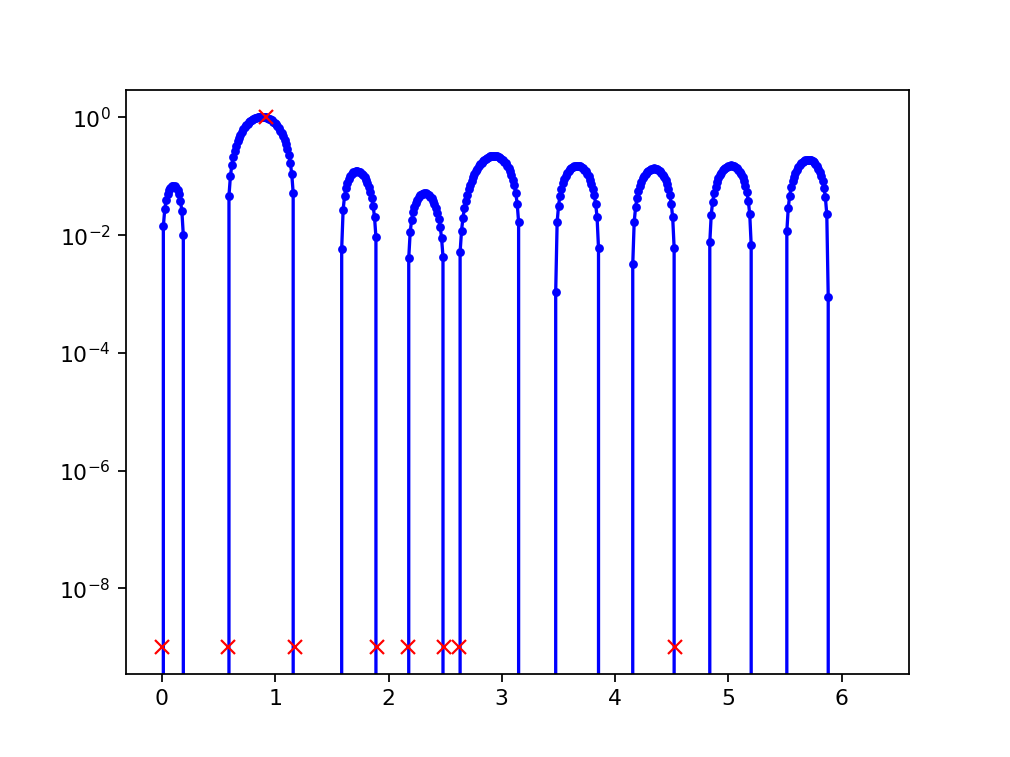

In [10]:
order = m
# n = 2*order + 1

x_test, y_hat, misfit = fit(X, Y, order)

plt.figure()
plt.semilogy(x_test, y_hat, 'b.-')
plt.semilogy(X, Y, 'rx')
plt.show()

Now there are still badly fitting spikes, but there peaks start to all go down...
The "noise energy" is getting spread across higher frequencies, and the average misfit to the truth goes down.


# Harmless overfitting? n = 10m

Way more parameters: now use 10 times the number of parameters as data points

Average misfit: 0.018012970909079603


<IPython.core.display.Javascript object>


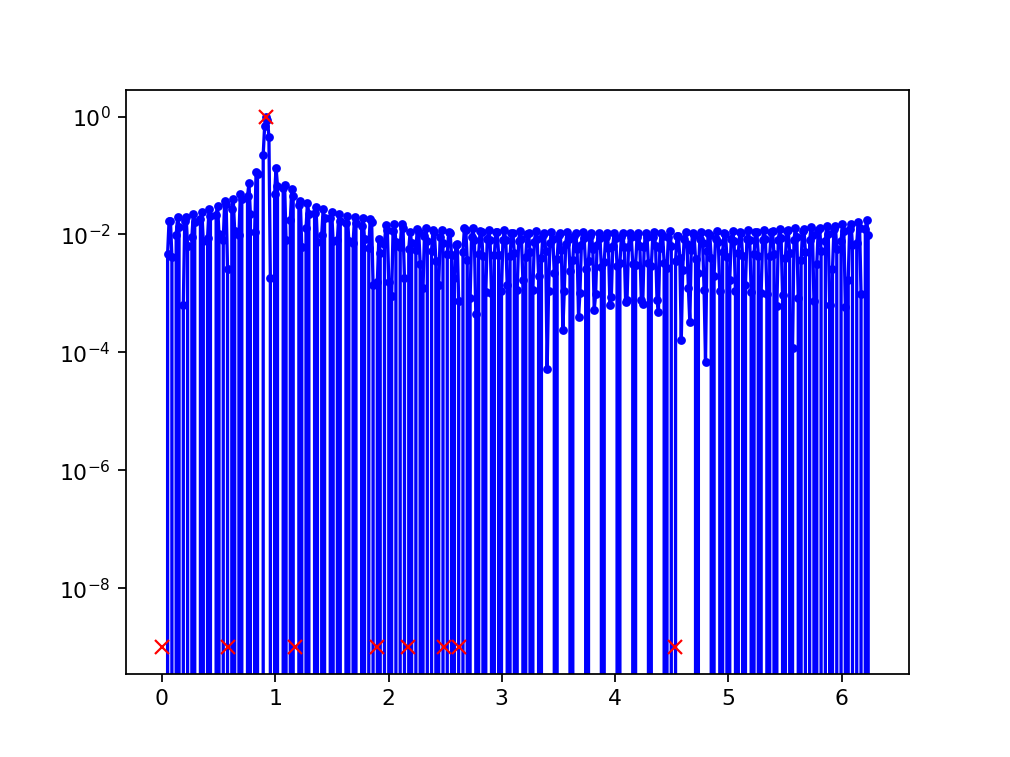

<IPython.core.display.Javascript object>


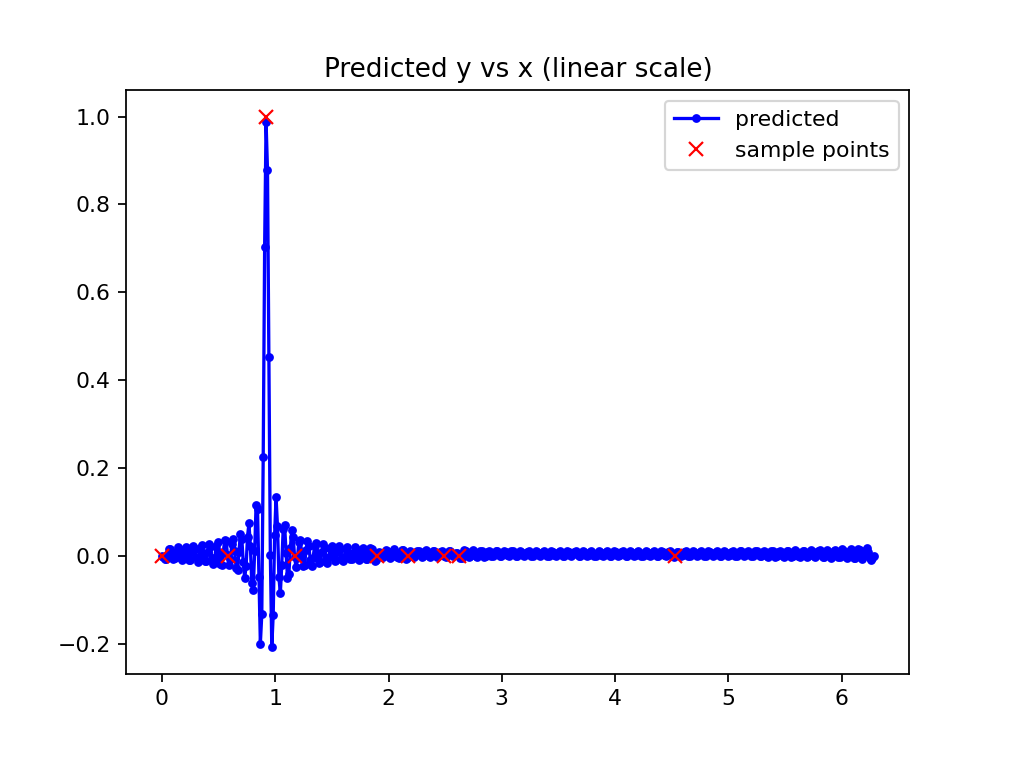

In [11]:
order = 10*m

x_test, y_hat, misfit = fit(X, Y, order)

plt.figure()
plt.semilogy(x_test, y_hat, 'b.-')
plt.semilogy(X, Y, 'rx')
plt.show()

plt.figure()
plt.plot(x_test, y_hat, 'b.-', label='predicted')
plt.plot(X, Y, 'rx', label='sample points')
plt.title("Predicted y vs x (linear scale)")
plt.legend()

# Show the misfit as a function of number of sin/cos terms

In [12]:
orders = list(range(0, m)) + list(np.logspace(np.log10(m), np.log10(8*m), 10).astype(int))
ns = 2*np.array(orders) + 1
# print(ns)

misfits = []
for order in orders:
    x_test, y_hat, misfit = fit(X, Y, order, print_misfit=False)
    misfits.append(misfit)


<IPython.core.display.Javascript object>


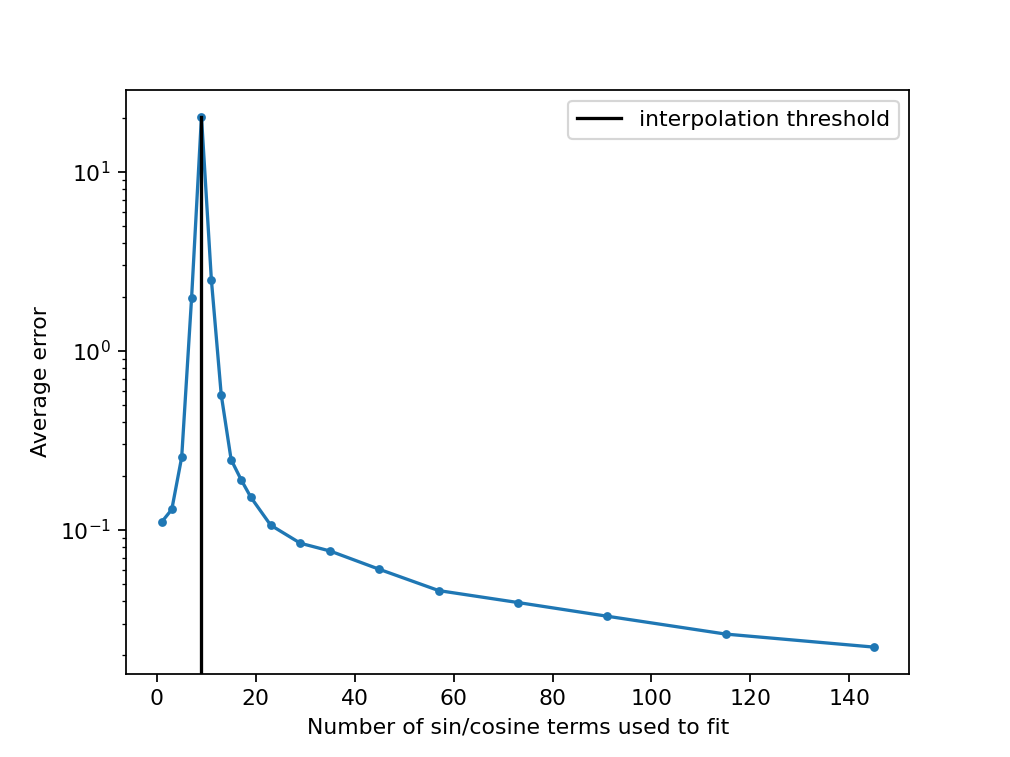

In [13]:
interp_thresh = m
plt.figure();
plt.semilogy(ns, misfits, '.-')
plt.semilogy(np.ones(5) * interp_thresh, np.linspace(0, np.max(misfits), 5), 'k-', label='interpolation threshold')
plt.ylabel("Average error")
plt.xlabel("Number of sin/cosine terms used to fit")
plt.legend()

### References
[1] Muthukumar, Vidya, et al. "Harmless interpolation of noisy data in regression." IEEE Journal on Selected Areas in Information Theory (2020).

The final figure is replicating one case from Figure 2: https://arxiv.org/pdf/1903.09139.pdf

# Random extra test: Fitting with a wide neural network

TODO: check similar "average error" graph as above with a NN of increasing width

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [15]:

nwide = 1000
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(1, nwide)
        self.fc2 = nn.Linear(nwide, nwide)
        self.fc3 = nn.Linear(nwide, 1)


    def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        
#         x = self.fc1(x)
#         x = self.fc2(x)
#         x = torch.tanh(self.fc1(x))
#         x = torch.tanh(self.fc2(x))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)


Net(
  (fc1): Linear(in_features=1, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=1, bias=True)
)


In [16]:
import torch.optim as optim

inp = torch.Tensor(X.reshape(-1, 1))
target = torch.Tensor(Y).view(-1, 1)

criterion = nn.MSELoss()

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

num_epochs = 5000
for epoch in range(num_epochs):
    # in your training loop:
    optimizer.zero_grad()   # zero the gradient buffers
    output = net(inp)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()    # Does the update
    if epoch % 500 == 0:
        print(f"{epoch = }, {loss.item() = }")


epoch = 0, loss.item() = 0.15103742480278015
epoch = 500, loss.item() = 0.05079585686326027
epoch = 1000, loss.item() = 0.028149651363492012
epoch = 1500, loss.item() = 0.008730195462703705
epoch = 2000, loss.item() = 0.003026040503755212
epoch = 2500, loss.item() = 0.000692488276399672
epoch = 3000, loss.item() = 0.00022584182443097234
epoch = 3500, loss.item() = 9.963271440938115e-05
epoch = 4000, loss.item() = 4.930593786411919e-05
epoch = 4500, loss.item() = 2.507205499568954e-05


<IPython.core.display.Javascript object>


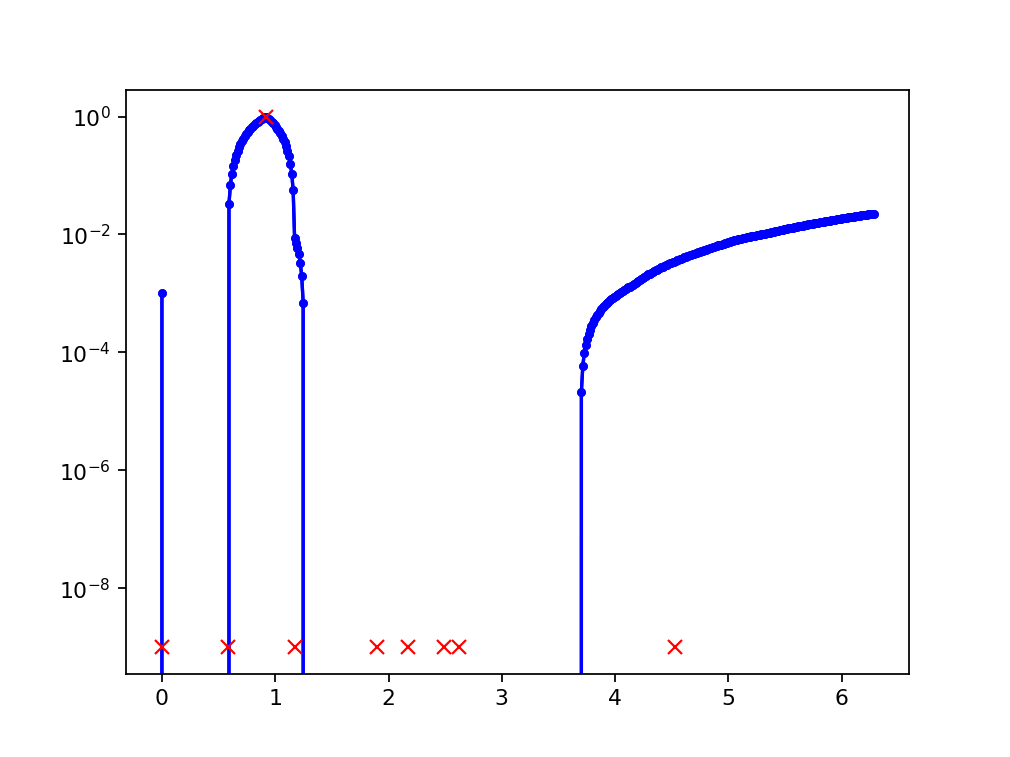

<IPython.core.display.Javascript object>


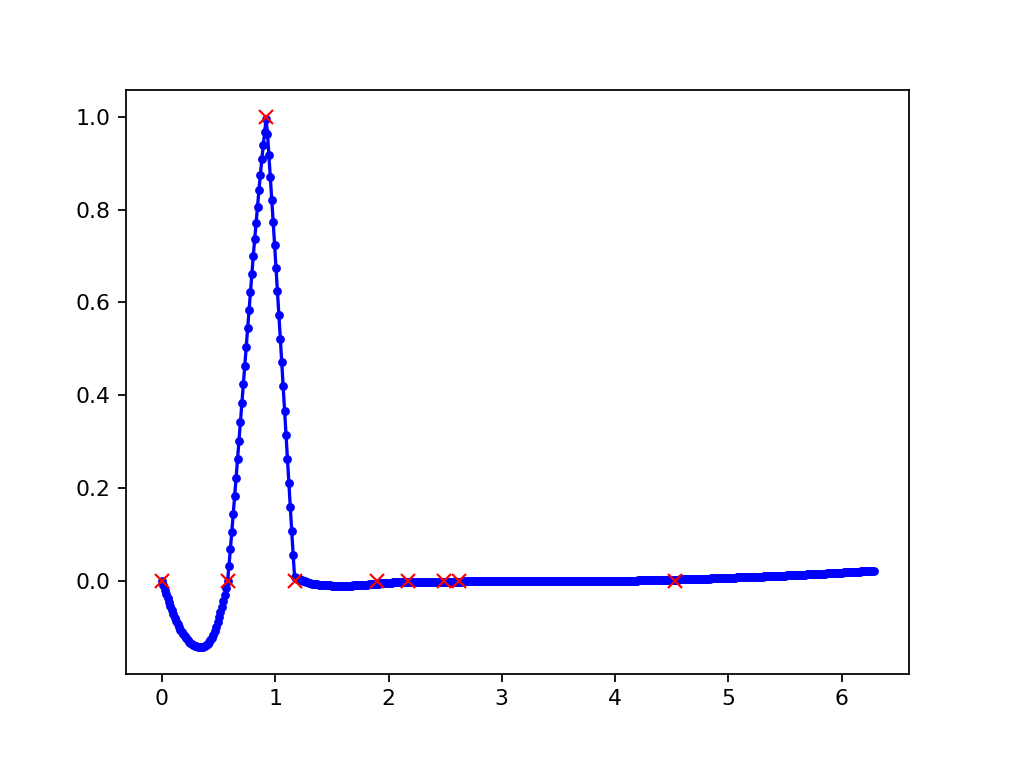

In [17]:
plt.figure()
x_test = np.linspace(0, X_MAX, 500).reshape(-1, 1)
y_test = net(torch.Tensor(x_test)).detach().numpy()

# xx, yy = inp.detach().numpy(), output.detach().numpy()
plt.plot(x_test, y_test, 'b.-')

plt.semilogy(x_test, y_test, 'b.-')
plt.semilogy(X, Y, 'rx')

plt.figure()
plt.plot(x_test, y_test, 'b.-')
plt.plot(X, Y, 'rx')